In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="MIG-f944a544-4758-56c2-81d7-94574c215198" 
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
device = "cuda:0"

In [2]:
from src.data.get_datamodules import get_pcna_data
data = get_pcna_data()

Jitting Chamfer 3D
Loaded JIT 3D CUDA chamfer distance
Loaded JIT 3D CUDA emd
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/usr/bin/ld: cannot find -lnvrtc
collect2: error: ld returned 1 exit status

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/usr/bin/ld: cannot find -lnvrtc
collect2: error: ld returned 1 exit status

OK


In [3]:
loss_eval_pc = instantiate(yaml.safe_load('''    
_aux: earthmovers
_target_: cyto_dl.nn.losses.GeomLoss
p: 1
blur: 0.01
'''))

In [4]:
data_list = [data[0], data[0], data[1], data[2], data[2], data[-1]]

In [5]:
from cyto_dl.models.utils.mlflow import load_model_from_checkpoint

run_ids = ['6bb8003c781e4661914a768763a352a3', 'f320f9b5bf6b4f0690fc5a173a81d7c8',
           '68157cde6680432292c3f5b959394bec',
           'b9f2bd234b0145a6920dec8f5ab62ba1', 'bcbc1ce667874430b6eb7d47c2abc1b3', 'dd001b5fa70a4e2c8f4738d3727add85']
run_names = ['2048_dgcnn','2048_ed_m2ae', '2048_int_ed_vndgcnn',
             'classical_resize_image', 'so2_resize_image', 'vit']
all_models = []
for i in run_ids:
    all_models.append(load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", i
                                  , path = "checkpoints/val/loss/best.ckpt", strict=False))

In [6]:
from tqdm import tqdm
import pandas as pd
from src.models.predict_model import process_batch
#Supress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

all_splits = []
all_cell_cycle = []
all_rotate = []
id = 'cell_id'
all_model_outputs = []
all_model_embeds = []
all_model_loss = []
all_model_ids = []
all_model_inputs = []
all_model_emissions = []
all_model_time = []
all_model_splits = []

# all_models_test = all_models[-1:]
# data_list_test = data_list[-1:]
# loss_list_test = loss_list[1:]
all_models_test = all_models
data_list_test = data_list
all_model_x_vis_list = []


for j_ind, model in enumerate(all_models_test):
    model = model.eval()
    all_data_inputs = []
    all_data_ids = []
    all_outputs = []
    all_embeds = []
    all_loss = []
    all_time = []
    all_emissions = []
    all_x_vis_list = []
    all_splits = []
    this_data = data_list_test[j_ind]
    # this_data = data_list[4]
    # this_loss = loss_list[4]
    with torch.no_grad():
        for i in tqdm(this_data.train_dataloader()):
            all_data_inputs, all_outputs, all_embeds, all_data_ids, all_splits, all_loss, all_emissions, all_x_vis_list = process_batch(
                model, loss_eval_pc, device, i, all_data_inputs, all_splits, all_data_ids, all_outputs, all_embeds, all_emissions, all_x_vis_list, all_loss, 'train', False
            )

        for i in tqdm(this_data.val_dataloader()):
            all_data_inputs, all_outputs, all_embeds, all_data_ids, all_splits, all_loss, all_emissions, all_x_vis_list= process_batch(
                model, loss_eval_pc, device, i, all_data_inputs, all_splits, all_data_ids, all_outputs, all_embeds, all_emissions, all_x_vis_list, all_loss, 'val', False,
            )
        count = 0
        for i in tqdm(this_data.test_dataloader()):
            if count < 1:
                track_emissions = True
            else:
                track_emissions = False
            count += 1
            all_data_inputs, all_outputs, all_embeds, all_data_ids, all_splits, all_loss, all_emissions, all_x_vis_list = process_batch(
                model, loss_eval_pc, device, i, all_data_inputs, all_splits, all_data_ids, all_outputs, all_embeds, all_emissions, all_x_vis_list, all_loss, 'test', track_emissions,
            )
        all_splits = [x for xs in all_splits for x in xs]
        all_data_ids = [x for xs in all_data_ids for x in xs]
        all_loss = [x for xs in all_loss for x in xs]
        all_data_inputs = [j.detach().cpu().numpy() for j in all_data_inputs]
        all_data_inputs = np.concatenate(all_data_inputs, axis=0)
        all_outputs = np.concatenate(all_outputs, axis=0)
        all_model_embeds.append(all_embeds)
        all_model_outputs.append(all_outputs)
        all_model_loss.append(all_loss)
        all_model_ids.append(all_data_ids)
        all_model_inputs.append(all_data_inputs)
        all_model_splits.append(all_splits)
        all_model_emissions.append(pd.concat(all_emissions, axis=0))
        all_model_x_vis_list.append(all_x_vis_list)

all_embeds2 = []
for embeds in all_model_embeds:
    # print(embeds.shape)
    embeds = np.concatenate(embeds, axis=0)
    all_embeds2.append(embeds)

100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


In [10]:
from pathlib import Path
Path("./benchmarking_outputs/").mkdir(parents=True, exist_ok=True)

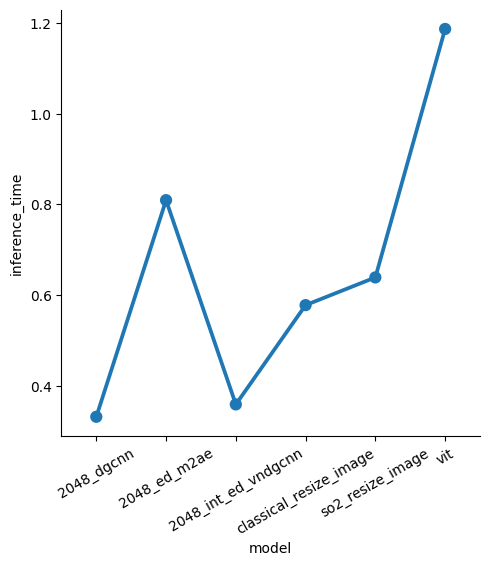

In [11]:
all_i = []
for j_ind2, i in enumerate(all_model_emissions):
    i['model'] = run_names[j_ind2]
    all_i.append(i)
emissions_df = pd.concat(all_i, axis=0).reset_index(drop=True)
import seaborn as sns
g = sns.catplot(data=emissions_df,x='model', y='inference_time', kind='point')
g.set_xticklabels(rotation=30)

emissions_df.to_csv('./benchmarking_outputs/pcna_emissions.csv')

In [17]:
import pandas as pd
all_ret = []
for j in range(len(all_models)):
    this_name = run_names[j]
        
    ret_dict = pd.DataFrame()
    this_embeds = np.squeeze(all_embeds2[j])
    if len(this_embeds.shape) > 2:
        this_embeds = np.squeeze(all_embeds2[-1])
        this_embeds2 = this_embeds[:,0,:]
        this_embeds = this_embeds[:,1:,:].mean(axis=1)
        ret_dict[[f"classtoken_{i}" for i in range(this_embeds.shape[1])]] = this_embeds2

    ret_dict[[f"mu_{i}" for i in range(this_embeds.shape[1])]] = this_embeds
    ret_dict['CellId'] = all_model_ids[j]
    ret_dict['loss'] = all_model_loss[j]
    ret_dict['model'] = run_names[j]
    ret_dict['split'] = all_model_splits[j]
    all_ret.append(ret_dict)
all_ret = pd.concat(all_ret, axis=0).reset_index(drop=True)

In [18]:
rec_df = all_ret.groupby(
    ['model', 'split']
).mean()

In [19]:
rec_df.to_csv('./benchmarking_outputs/pcna_recon.csv')

In [20]:
df = pd.read_csv('/allen/aics/assay-dev/computational/data/4DN_handoff_Apr2022_testing/PCNA_manifest_for_suraj_with_brightfield.csv')
all_ret = all_ret.merge(df, on='CellId')

In [22]:
from src.features.outlier_compactness import get_embedding_metrics
ret_dict_compactness = get_embedding_metrics(all_ret)

  0%|          | 0/6 [00:00<?, ?it/s]

(2420, 256)


 17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]

(2420, 192)


 33%|███▎      | 2/6 [00:00<00:01,  2.08it/s]

(2420, 256)


 50%|█████     | 3/6 [00:01<00:01,  2.02it/s]

(2420, 256)


 67%|██████▋   | 4/6 [00:02<00:01,  1.98it/s]

(2420, 256)


 83%|████████▎ | 5/6 [00:02<00:00,  1.97it/s]

(2420, 256)


100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


In [23]:
from src.features.classification import get_classification_df
ret_dict_classification = get_classification_df(all_ret)

100%|██████████| 6/6 [02:14<00:00, 22.35s/it]


In [24]:
ret_dict_classification.to_csv('./benchmarking_outputs/pcna_classification.csv')

In [25]:
len(data_list)

6

In [31]:
from src.features.rotation_invariance import get_equiv_dict
keys = ["pcloud", "pcloud", "pcloud", "image", "image", "image", "image"]
eq_dict = get_equiv_dict(all_models, data_list, device, loss_eval_pc, keys)

 25%|██▌       | 2/8 [01:21<04:00, 40.05s/it]

In [ ]:
ret_dict_equiv.to_csv('./benchmarking_outputs/pcna_equiv.csv')

In [ ]:
from src.features.evolve import get_evolution_dict
keys = ["pcloud", "pcloud", "pcloud", "image", "image", "image"]
evolution_dict = get_evolution_dict(
    all_models,
    all_model_inputs,
    loss_eval_pc,
    all_embeds2,
    all_model_ids,
    run_names,
    device,
    df, 
    keys)